In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt


In [2]:
tf.__version__

'2.9.0'

## Set constants

In [3]:
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 50
BATCH_SIZE = 32

## Import data into tensorflow dataset object

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed = 123,
    shuffle = True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [5]:
print(dataset.batch)

classes_names = dataset.class_names
classes_names

<bound method DatasetV2.batch of <BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>>


['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
len(dataset)

68

In [7]:
for image_batch, labels_batch in dataset.take(1):
    print(type(image_batch))
    print(type(labels_batch))
    print(image_batch.shape)
    print(labels_batch.numpy())

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


## Visualize some of the images from our dataset

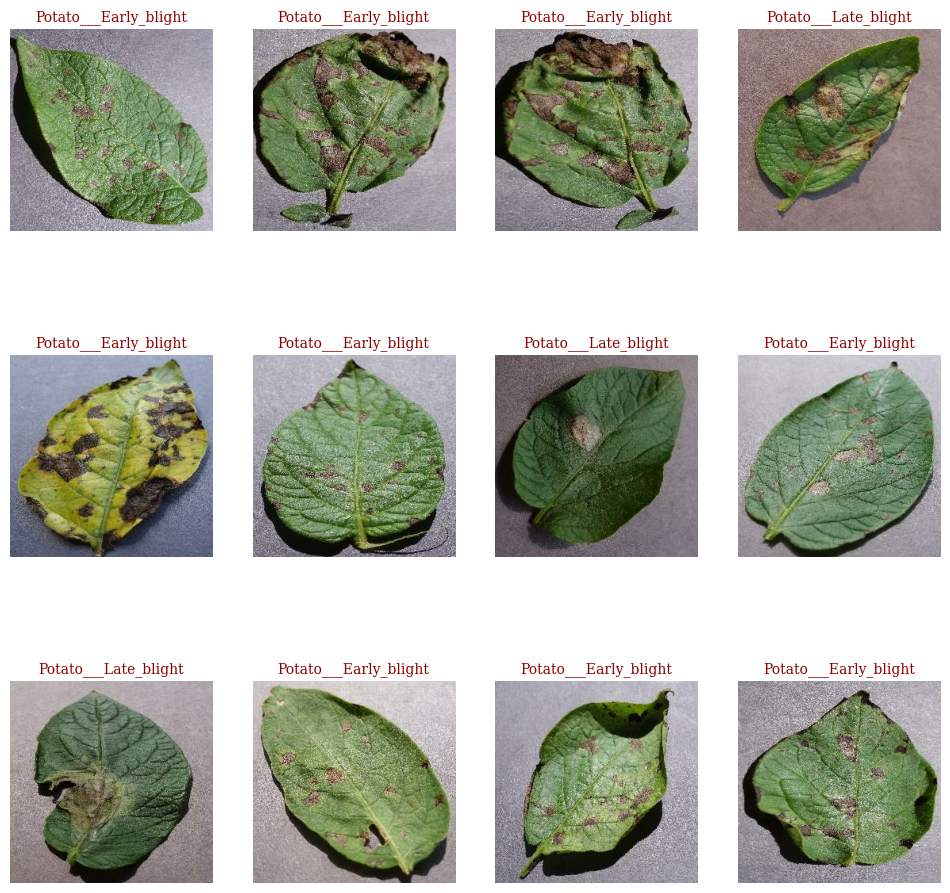

In [8]:

font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 10,
        }


plt.figure(figsize = (12,12))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype(int))
        plt.title(classes_names[labels_batch[i]],fontdict= font)
        plt.axis("off")

## Function to Split Dataset

In [9]:
def partition_of_dataset(ds,train_size = 0.8,test_size = 0.1,val_size = 0.1,shuffle = True,shuffle_size = 10000):
    assert (train_size + test_size + val_size) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed = 12)
        
    train_size = int(ds_size * train_size)
    val_size = int(val_size * ds_size)
    
    train_ds = ds.take(train_size) 
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds
    

In [10]:
train_ds, val_ds, test_ds = partition_of_dataset(dataset)

In [11]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

54
6
8


## Cache, Shuffle, and Prefetch the Dataset

In [12]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


## Building the Model

### Creating a Layer for Resizing and Normalization

In [13]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255)
])

### Data Augmentation

###### Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [14]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

### Applying Data Augmentation to Train Dataset

In [15]:
train_ds = train_ds.map(
    lambda x,y:(data_augmentation(x,training = True),y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

## Model Architecture

In [16]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32,kernel_size = (3,3),activation = 'relu',input_shape=input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])


In [17]:
model.build(input_shape=input_shape)

In [18]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

## Compiling the Model

In [19]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [20]:
history = model.fit(train_ds,
                    batch_size=BATCH_SIZE,
                    verbose=1,
                    epochs = 40,
                    
                    validation_data=val_ds)

Epoch 1/40
54/54 [==============================] - 77s 1s/step - loss: 0.9260 - accuracy: 0.4855 - val_loss: 0.8712 - val_accuracy: 0.4896
Epoch 2/40
54/54 [==============================] - 72s 1s/step - loss: 0.8210 - accuracy: 0.6047 - val_loss: 0.8070 - val_accuracy: 0.5729
Epoch 3/40
54/54 [==============================] - 73s 1s/step - loss: 0.5688 - accuracy: 0.7633 - val_loss: 0.4758 - val_accuracy: 0.7865
Epoch 4/40
54/54 [==============================] - 73s 1s/step - loss: 0.4008 - accuracy: 0.8380 - val_loss: 0.3748 - val_accuracy: 0.8542
Epoch 5/40
54/54 [==============================] - 72s 1s/step - loss: 0.2805 - accuracy: 0.8929 - val_loss: 0.5018 - val_accuracy: 0.8177
Epoch 6/40
54/54 [==============================] - 72s 1s/step - loss: 0.3163 - accuracy: 0.8814 - val_loss: 0.2274 - val_accuracy: 0.8958
Epoch 7/40
54/54 [==============================] - 73s 1s/step - loss: 0.2622 - accuracy: 0.8895 - val_loss: 0.3391 - val_accuracy: 0.8542
Epoch 8/40
54/54 [==

## Plotting the Accuracy and Loss Curves

In [21]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [22]:
history.params

{'verbose': 1, 'epochs': 40, 'steps': 54}

In [23]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

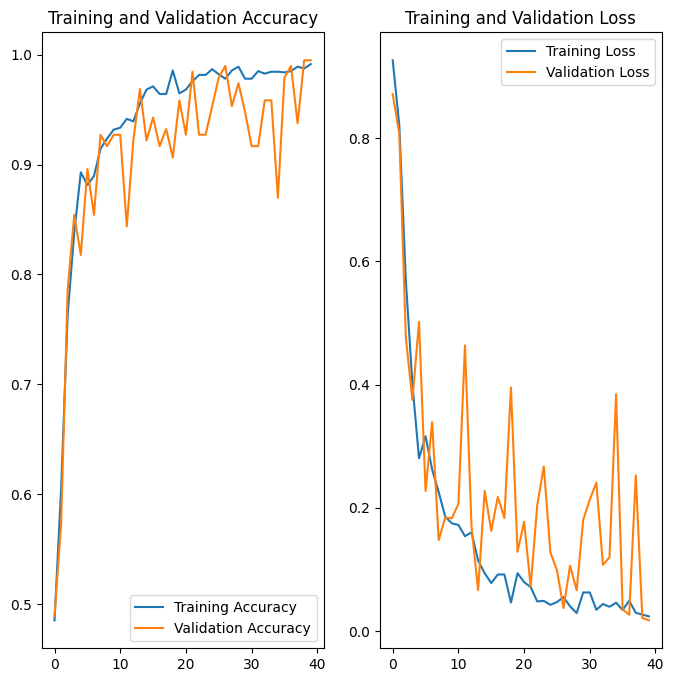

In [24]:
EPOCHS=40
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [25]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 6s 310ms/step - loss: 0.0290 - accuracy: 0.9922


In [26]:
scores

[0.028980910778045654, 0.9921875]

## Run prediction on a sample image

first image to predict
actual label : Potato___Late_blight
1/1 [==============================] - 0s 448ms/step
predicted label: Potato___Late_blight


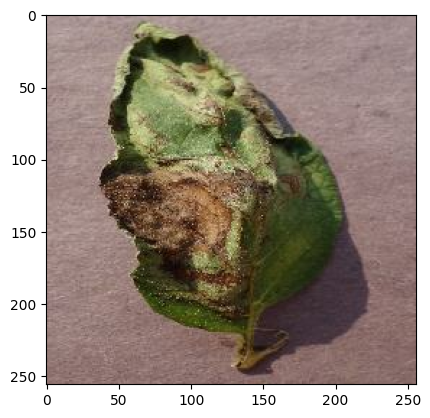

In [27]:
import numpy as np

for image_batch,label_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype(int)
    fitst_label = label_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label :", classes_names[fitst_label])
    
        
    batch_prediction = model.predict(image_batch)
    print("predicted label:",classes_names[np.argmax(batch_prediction[0])])

## Write a function for inference

In [28]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = classes_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

### Now run inference on few sample images

1/1 [==============================] - 0s 29ms/step


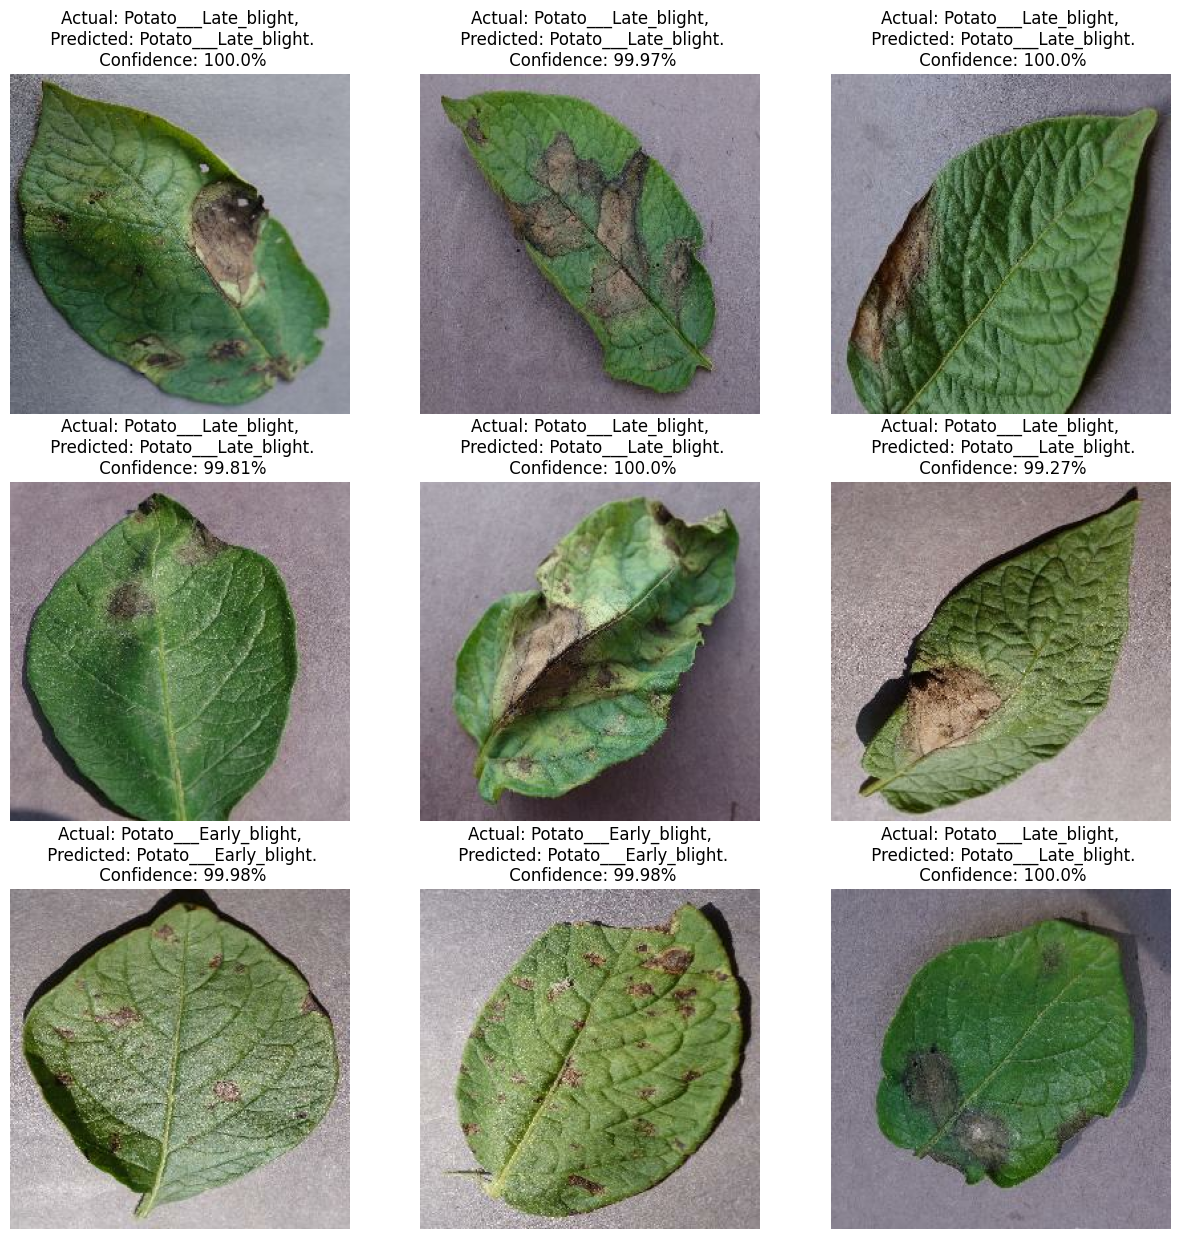

In [29]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = classes_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

### Saving the Model

In [30]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets


In [31]:
model.save("../potatoes.h5")